In [1]:
import pandas as pd
import numpy as np
import csv
import random
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [114]:
import warnings
warnings.filterwarnings("ignore")

In [115]:
data = pd.read_csv('for_reviews_acc.csv').dropna()
data.head(5)

,user_id,item_id,playtime_forever,play_after_buy,review,fix_recommend,review_label
0,76561197970982479,22200,271,True,It's unique and worth a playthrough.,True,1
1,76561197970982479,1250,10006,True,Simple yet with great replayability. In my opi...,True,1
2,76561197970982479,43110,834,True,Great atmosphere. The gunplay can be a bit chu...,True,1
3,js41637,227300,551,True,For a simple (it's actually not all that simpl...,True,1
4,js41637,239030,349,True,Very fun little game to play when your bored o...,True,1


In [116]:
len(data)

44166

In [117]:
data_review = data['review'].to_list()
data_review[:5]

["It's unique and worth a playthrough.",
 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.',
 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!',
 "For a simple (it's actually not all that simple but it can be!) truck driving Simulator, it is quite a fun and relaxing game. Playing on simple (or easy?) its just the basic WASD keys for driving but (if you want) the game can be much harder and realistic with having to manually change gears, much harder turning, etc. And reversing in this game is a ♥♥♥♥♥, as I imagine it would be with an actual truck. Luckily, you don't have to reverse park it but you get extra points if you do cause it is bloody hard. But thi

In [118]:
for i,x in enumerate(data_review):
    if type(x)==float:
        print(i,x)

# review_len[:5]

Review Feature Extraction

In [119]:
review_len = [len(x) for x in data_review]
review_len[:5]

[36, 249, 182, 590, 97]

In [120]:
# review_eff_len = [len(''.join(x.split())) for x in data_review]
from collections import Counter
review_eff_len = []
for x in data_review:
    res = 0
    c = Counter(x)
    for key in c.keys():
        if key.isalnum(): res+=c[key]
    review_eff_len.append(res)
review_eff_len[:5]

[29, 197, 139, 450, 75]

In [121]:
data_np = data.to_numpy()
data_np[0]

array(['76561197970982479', 22200, 271, True,
       "It's unique and worth a playthrough.", True, 1], dtype=object)

In [122]:
review_emo_per_game = defaultdict(list)
review_emo_per_user = defaultdict(list)

for user,item,playtime_forever,play_after_buy,review,fix_recommend,review_labe in data_np:
    review_emo_per_user[user].append(review_labe)
    review_emo_per_game[item].append(review_labe)

In [123]:
review_avg_emo_per_game = defaultdict(int)
review_avg_emo_per_user = defaultdict(int)

for user in review_emo_per_user.keys():
    rates = review_emo_per_user[user]
    review_avg_emo_per_user[user] = sum(rates)/len(rates)
for item in review_emo_per_game.keys():
    rates = review_emo_per_game[item]
    review_avg_emo_per_game[item] = sum(rates)/len(rates)

In [124]:
review_avg_emo_by_user = []
review_avg_emo_by_game = [] 
for l in data_np:
    review_avg_emo_by_user.append(review_avg_emo_per_user[l[0]])
    review_avg_emo_by_game.append(review_avg_emo_per_game[l[1]])

In [125]:
# user,item,playtime_forever,play_after_buy,review,fix_recommend,review_labe,review_len,review_eff_len,review_avg_emo_by_user,review_avg_emo_by_game
review_len_np = np.asarray(review_len).reshape((-1,1))
review_eff_len_np = np.asarray(review_eff_len).reshape((-1,1))
review_avg_emo_by_user_np = np.asarray(review_avg_emo_by_user).reshape((-1,1))
review_avg_emo_by_game_np = np.asarray(review_avg_emo_by_game).reshape((-1,1))
data_np_new = np.hstack((data_np,review_len_np,review_eff_len_np,review_avg_emo_by_user_np,review_avg_emo_by_game_np))

data_np_new[0]

array(['76561197970982479', 22200, 271, True,
       "It's unique and worth a playthrough.", True, 1, 36, 29, 1.0, 0.8],
      dtype=object)

In [126]:
data_np_new_x_num_only = np.hstack((data_np_new[:,2:4],data_np_new[:,5:11]))
# data_np_new_y_num_only = data_np_new[:,5]
# data_np_new[:,6:10][0]
coeff = np.corrcoef(data_np_new_x_num_only.astype(float), rowvar=False)

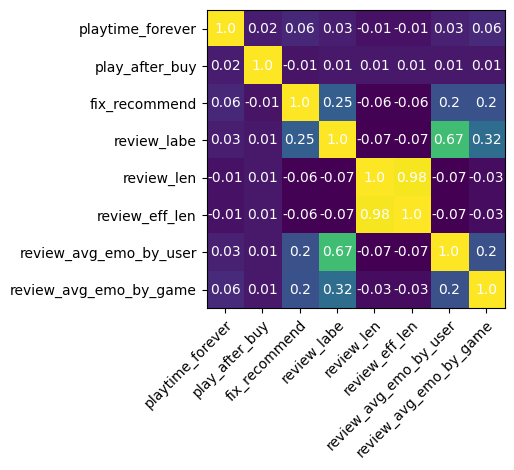

In [127]:
import matplotlib as mpl

x_label = ['playtime_forever','play_after_buy','fix_recommend','review_labe',
'review_len','review_eff_len','review_avg_emo_by_user','review_avg_emo_by_game']

fig, ax = plt.subplots()
im = ax.imshow(coeff)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(x_label)), labels=x_label)
ax.set_yticks(np.arange(len(x_label)), labels=x_label)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x_label)):
    for j in range(len(x_label)):
        text = ax.text(j, i, round(coeff[i, j],2),
                       ha="center", va="center", color="w")

# ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [128]:
y = data_np_new[:,5]
X = np.hstack((data_np_new[:,6:7],data_np_new[:,9:11]))


In [129]:
len(X[0])

3

In [130]:
len(X)

44166